---
# ClusterBasedWSelector_609 look at specific cpd activity vs uncertainty scores
## Why are exploration models able to find many actives?

In [1]:
from active_learning_dd.models.supervised  import *
from active_learning_dd.utils.data_utils  import *
import pandas as pd
import numpy as np
import glob
import warnings
warnings.simplefilter("ignore")
%load_ext autoreload
%autoreload 2

root_dir = '../../../aldd_results/aldd_exp_3_final//params_results\\'

Using TensorFlow backend.


---
# Using RF and default uncertainty (distance from 0.5)

In [80]:
def run_rf(task_col, hit_perc, hit_limit, uncert_method='least_confidence', normalize_uncert=False):
    af = root_dir+'sampled_hyparams/ClusterBasedWCSelector_609/{}/0/batch_size_96/'.format(task_col)
    for iter_max in [1, 10, 20, 30, 40, 50]:
        train_files = [af+'/training_data/iter_{}.csv'.format(i) for i in range(iter_max)]

        train_df = pd.concat([pd.read_csv(x) for x in train_files])
        unlabeled_df = pd.concat([pd.read_csv(x) for x in glob.glob('../datasets/pcba/{}_cv_96/*.csv'.format(task_col))])
        unlabeled_df = unlabeled_df.drop_duplicates('Index ID')
        unlabeled_df = unlabeled_df[~unlabeled_df['Index ID'].isin(train_df['Index ID'].values)]

        X_train = np.vstack([ (np.fromstring(x, 'u1') - ord('0')).astype(np.uint16) for x in train_df['Morgan FP_2_1024'] ])
        X_test = np.vstack([ (np.fromstring(x, 'u1') - ord('0')).astype(np.uint16) for x in unlabeled_df['Morgan FP_2_1024'] ])
        y_train, y_test = train_df[task_col].values.reshape(-1,1), unlabeled_df[task_col].values.reshape(-1,1)

        model = sklearn_randomforest.SklearnRF(task_names=[task_col],
                                               n_estimators=50,
                                               max_features="log2",
                                               min_samples_leaf=1,
                                               n_jobs=1,
                                               class_weight="balanced",
                                               random_state=20183112,
                                               oob_score=False,
                                               verbose=0)
        model.fit(X_train, y_train)
        train_preds = model.predict(X_train)
        test_preds = model.predict(X_test)
        test_uncert = model.get_uncertainty(X_test, uncert_method, [])
        
        if normalize_uncert:
            x = (test_preds - np.min(test_preds)) / (np.max(test_preds) - np.min(test_preds))
            test_uncert = 1 - (np.abs(2*x - 1))

        test_actives = np.where(y_test[:,0] == 1)[0]
        test_inactives = np.where(y_test[:,0] == 0)[0]
        
        topk = 96
        x = test_preds[:,0].argsort()[::-1][:topk]
        y = test_uncert[:,0].argsort()[::-1][:topk]
        overlap = np.intersect1d(x, y).shape[0]
        
        import seaborn as sns
        import matplotlib.pyplot as plt
        sns.set_context("paper")
        sns.set(font_scale=3.0)

        fontsize=32
        figsize=(22, 12)
        fig_title = 'Task {} RF predictions kernel density estimate after {} iteration\nwith {} training compounds and {} unlabeled pool compounds.'.format(task_col,
                                                                                                                                     iter_max, 
                                                                                                                                     y_train.shape[0],
                                                                                                                                     y_test.shape[0])
        fig_title += ' # Hits in dataset: {}.' .format(hit_limit)
        fig_title += '\n\n# Compound overlap between top {} predictions and uncertainty scores: {} compounds.'.format(topk, overlap)
        fig, axes = plt.subplots(1, 2, figsize=figsize)
        sns.distplot(test_preds[test_actives,0], kde_kws={"linewidth": 3, 'alpha': 0}, ax=axes[0], color='darkgreen', hist_kws={"alpha": 0.6}, kde=False, norm_hist=True)
        sns.distplot(test_preds[test_inactives,0], kde_kws={"linewidth": 2}, ax=axes[0], color='coral', hist_kws={"alpha": 0.7}, kde=False, norm_hist=True)
        axes[0].legend(['hits', 'non-hits'])
        axes[0].set_title('RF predictions distribution', fontsize=fontsize)



        sns.distplot(test_uncert[test_actives,0], kde_kws={"linewidth": 3}, ax=axes[1], color='darkgreen', hist_kws={"alpha": 0.6}, kde=False, norm_hist=True)
        sns.distplot(test_uncert[test_inactives,0], kde_kws={"linewidth": 2}, ax=axes[1], color='coral', hist_kws={"alpha": 0.7}, kde=False, norm_hist=True)
        axes[1].legend(['hits', 'non-hits'])
        axes[1].set_title('RF uncertainty (distance from 0.5) distribution', fontsize=fontsize)


        fig.suptitle(fig_title, fontsize=36)
        fig.tight_layout()
        fig.subplots_adjust(top=.745)
        plt.savefig('./exp3/why_exploration/task_{}_{}.png'.format(task_col, iter_max))
        plt.show()

In [7]:
task_col, hit_perc, hit_limit = 'pcba-aid588456', 0.01, 51
run_rf(task_col, hit_perc, hit_limit)

<Figure size 2200x1000 with 2 Axes>

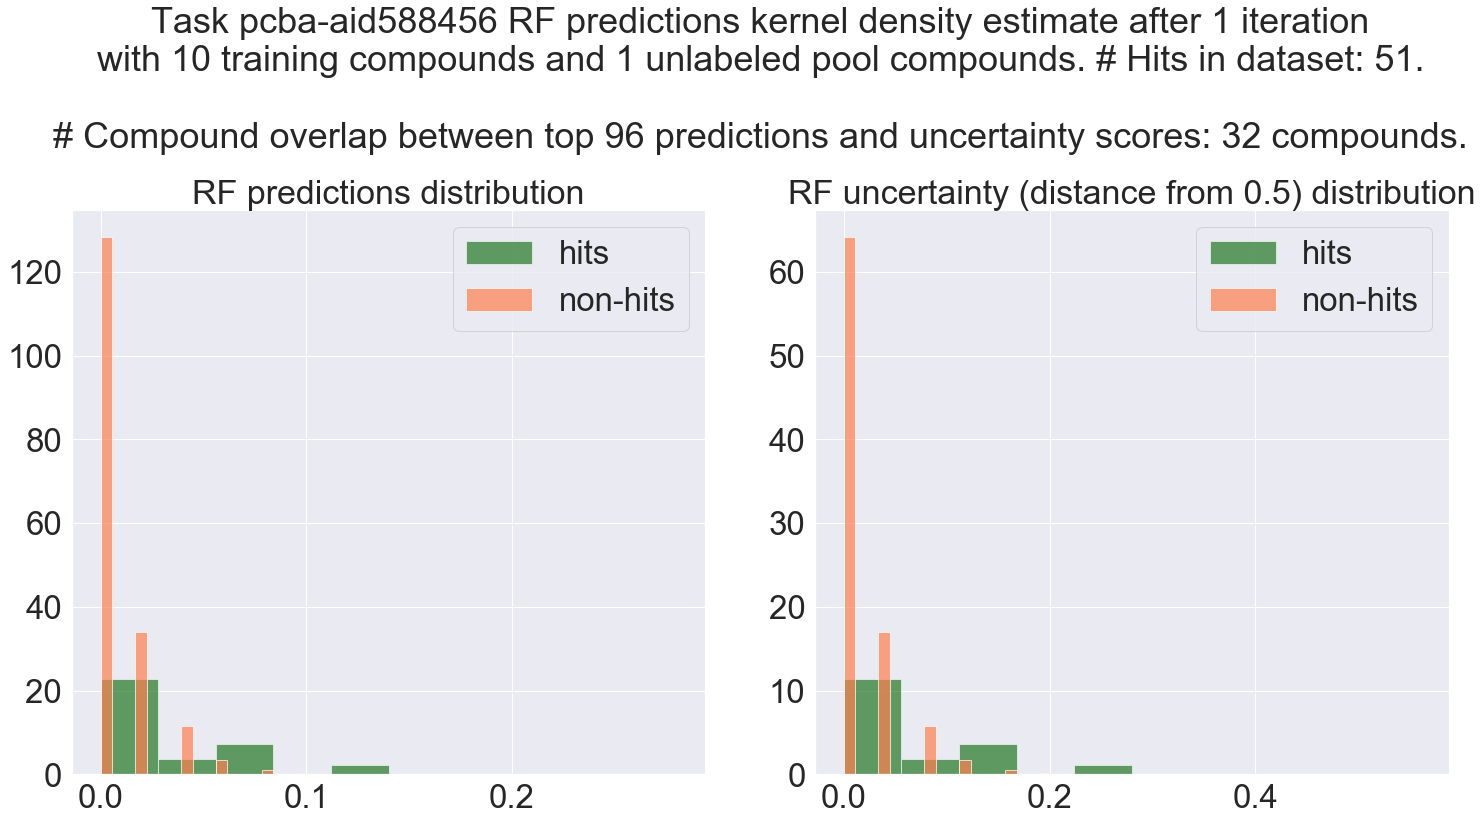

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context("paper")
sns.set(font_scale=3.0)

fontsize=34
figsize=(22, 12)
fig_title = 'Task {} RF predictions kernel density estimate after {} iteration\nwith {} training compounds and {} unlabeled pool compounds.'.format(task_col,
                                                                                                                             1, 
                                                                                                                             10,
                                                                                                                             1)
fig_title += ' # Hits in dataset: {}.' .format(hit_limit)
fig_title += '\n\n# Compound overlap between top {} predictions and uncertainty scores: {} compounds.'.format(96, 32)
fig, axes = plt.subplots(1, 2, figsize=figsize)
sns.distplot(test_preds[test_actives,0], kde_kws={"linewidth": 3, 'alpha': 0}, ax=axes[0], color='darkgreen', hist_kws={"alpha": 0.6}, kde=False, norm_hist=True)
sns.distplot(test_preds[test_inactives,0], kde_kws={"linewidth": 3}, ax=axes[0], color='coral', hist_kws={"alpha": 0.7}, kde=False, norm_hist=True)
axes[0].legend(['hits', 'non-hits'])
axes[0].set_title('RF predictions distribution', fontsize=fontsize)



sns.distplot(test_uncert[test_actives,0],kde_kws={"linewidth": 3}, ax=axes[1], color='darkgreen', hist_kws={"alpha": 0.6}, kde=False, norm_hist=True)
sns.distplot(test_uncert[test_inactives,0], kde_kws={"linewidth": 2}, ax=axes[1], color='coral', hist_kws={"alpha": 0.7}, kde=False, norm_hist=True)
axes[1].legend(['hits', 'non-hits'])
axes[1].set_title('RF uncertainty (distance from 0.5) distribution', fontsize=fontsize)


fig.suptitle(fig_title, fontsize=36)
fig.tight_layout()
fig.subplots_adjust(top=.745)
plt.show()

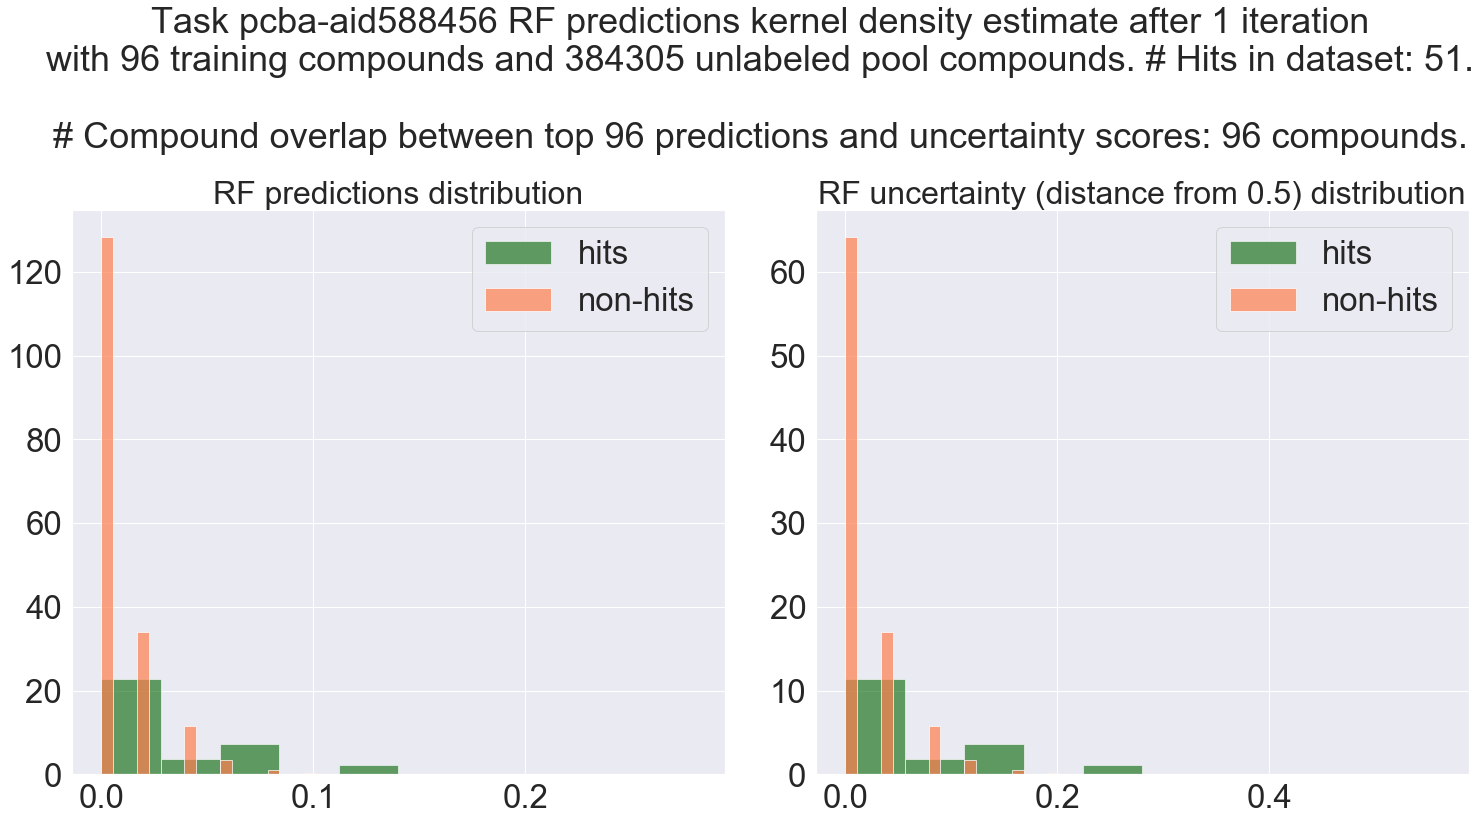

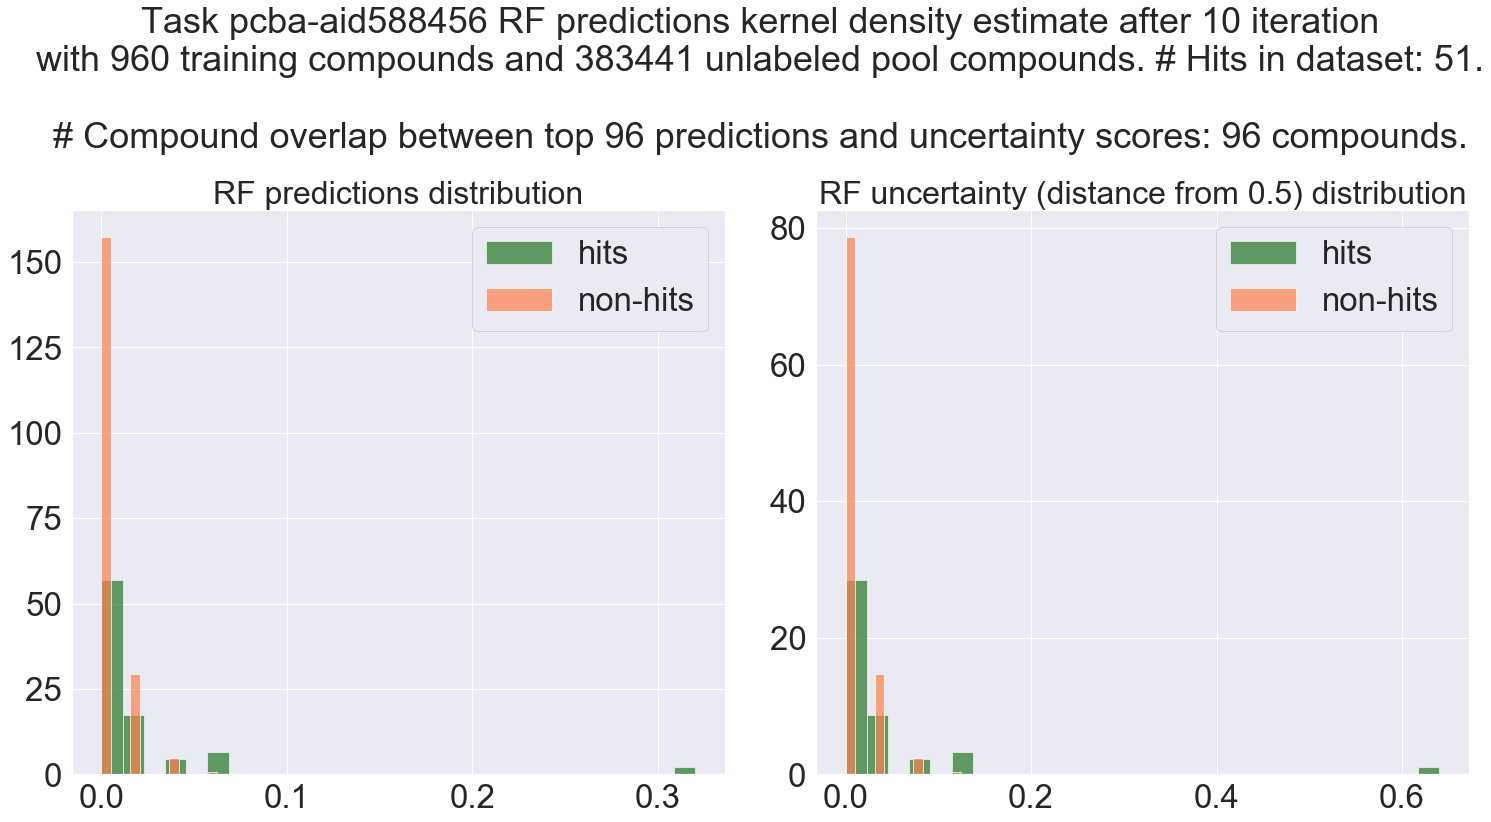

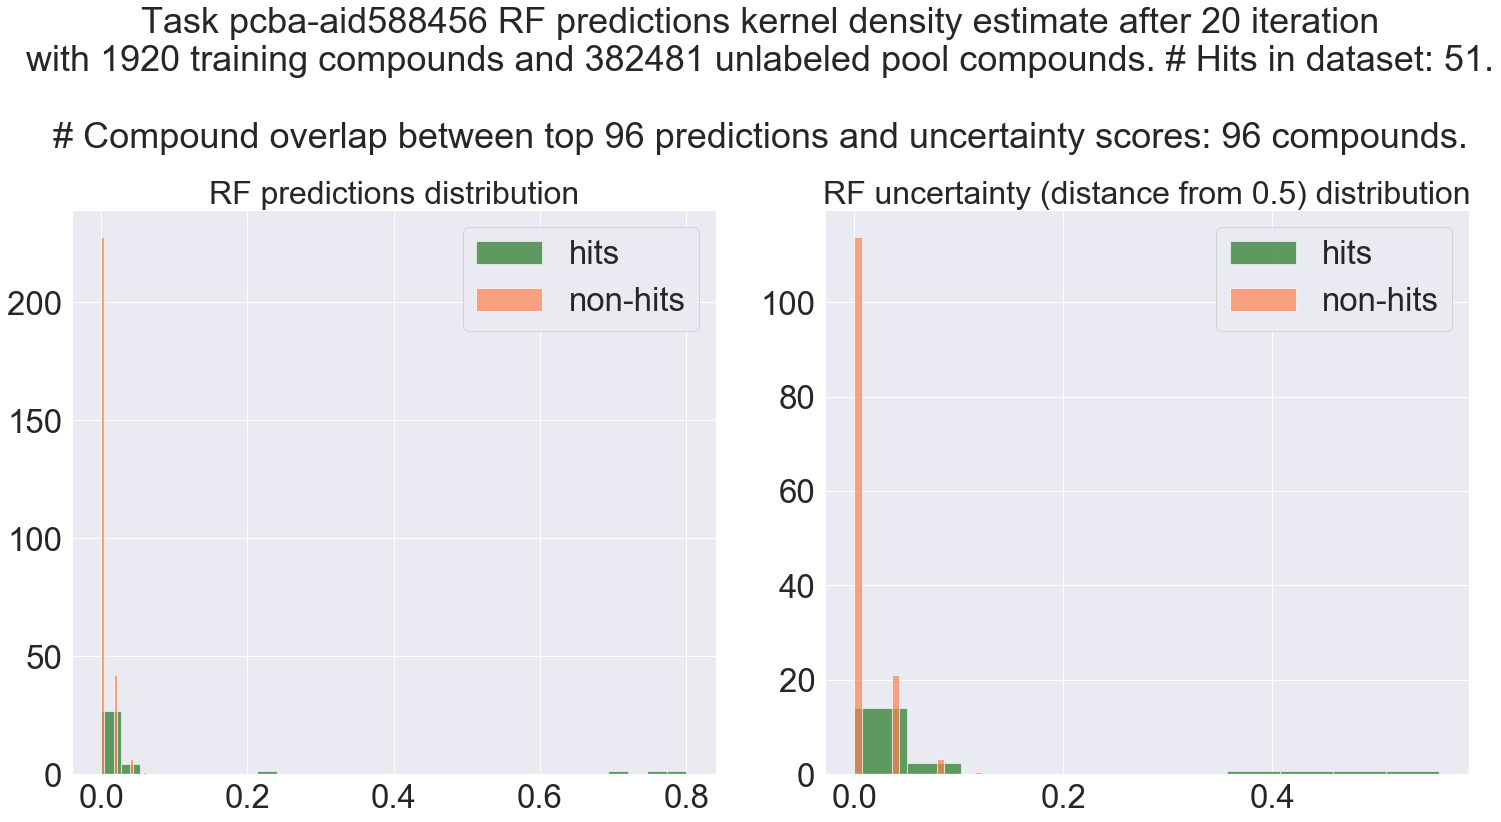

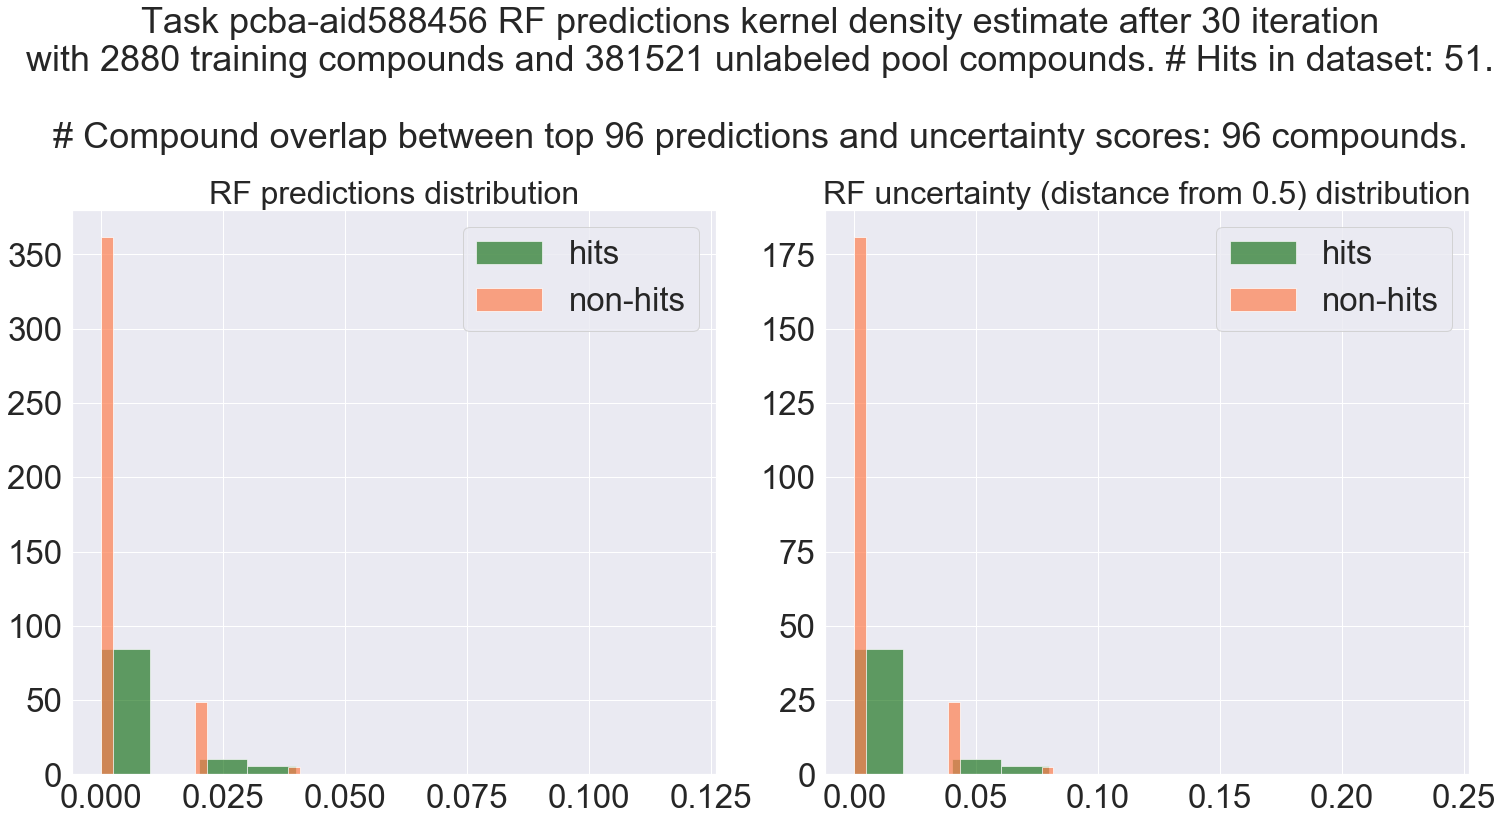

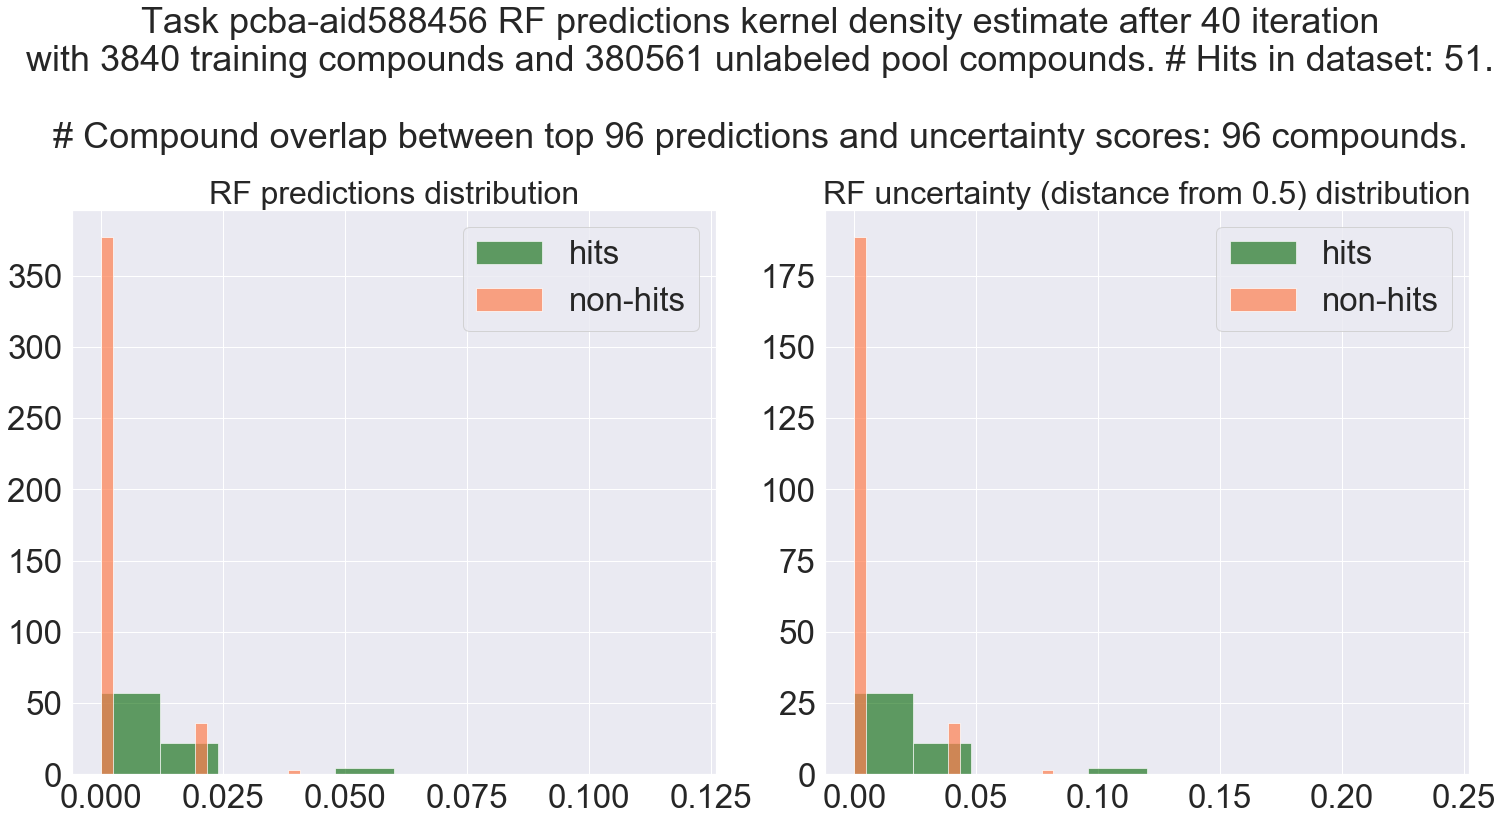

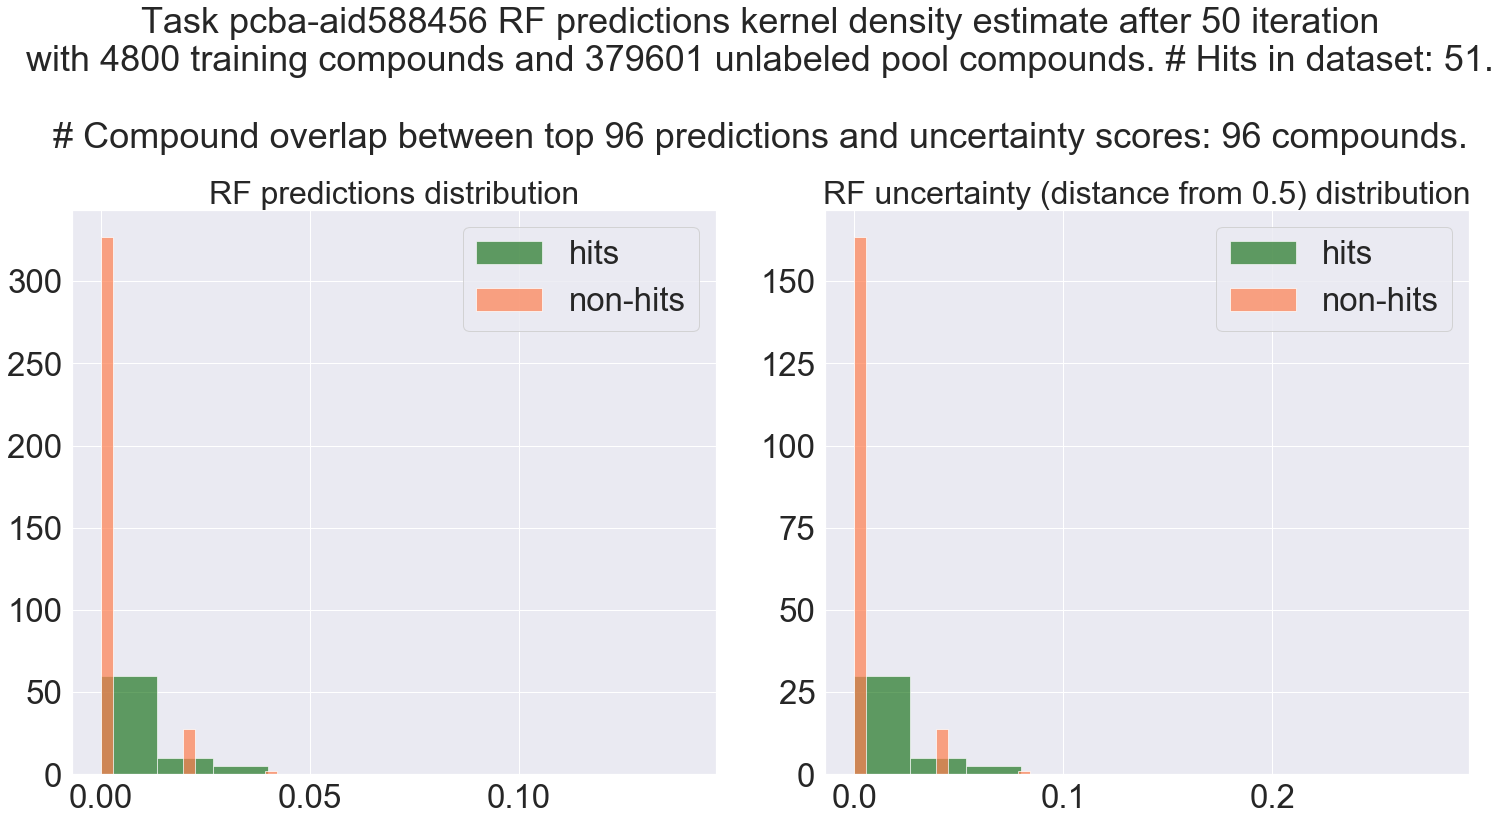

In [81]:
task_col, hit_perc, hit_limit = 'pcba-aid588456', 0.01, 51
run_rf(task_col, hit_perc, hit_limit)

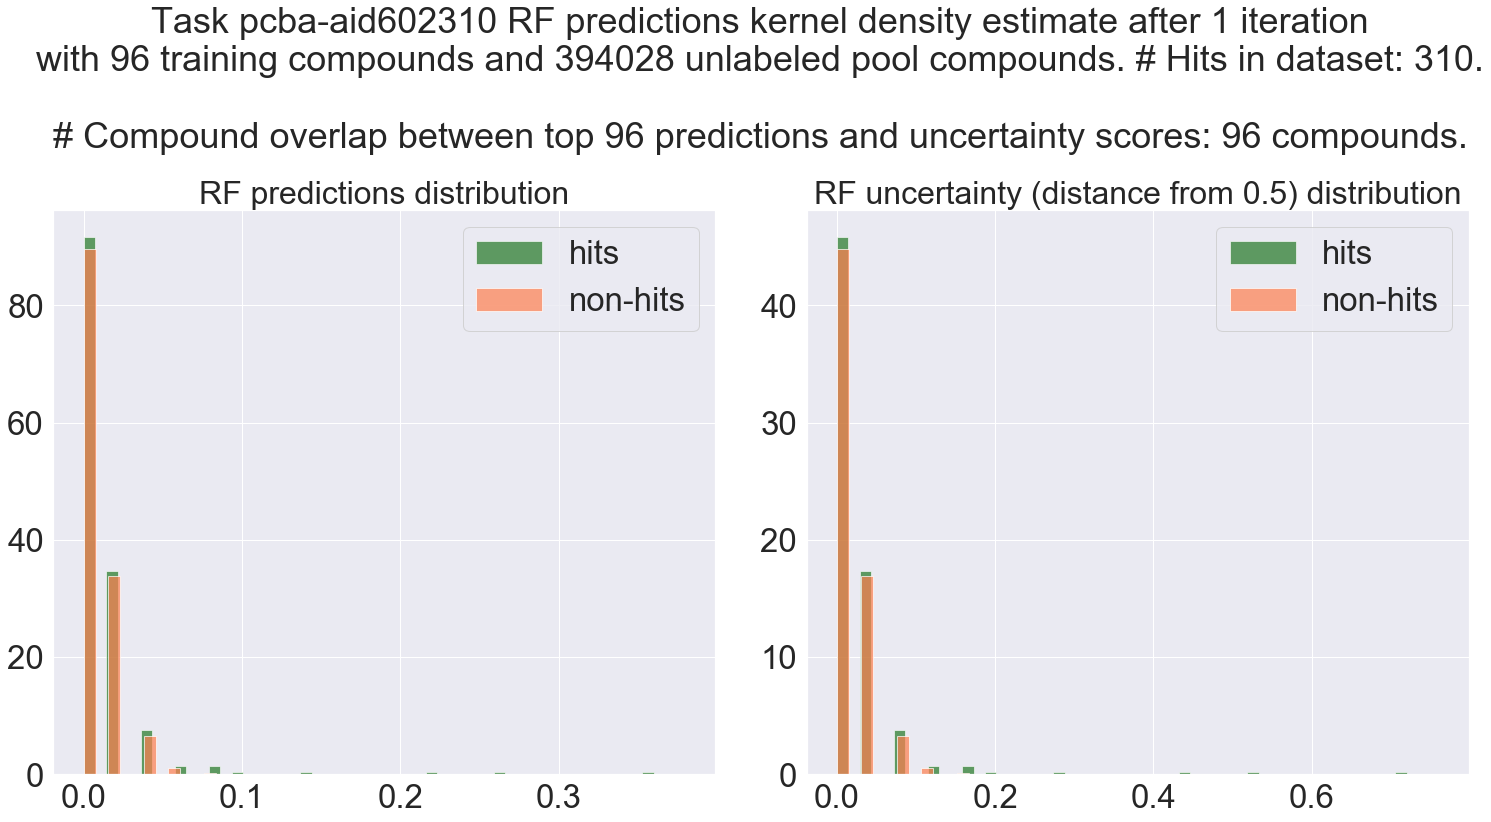

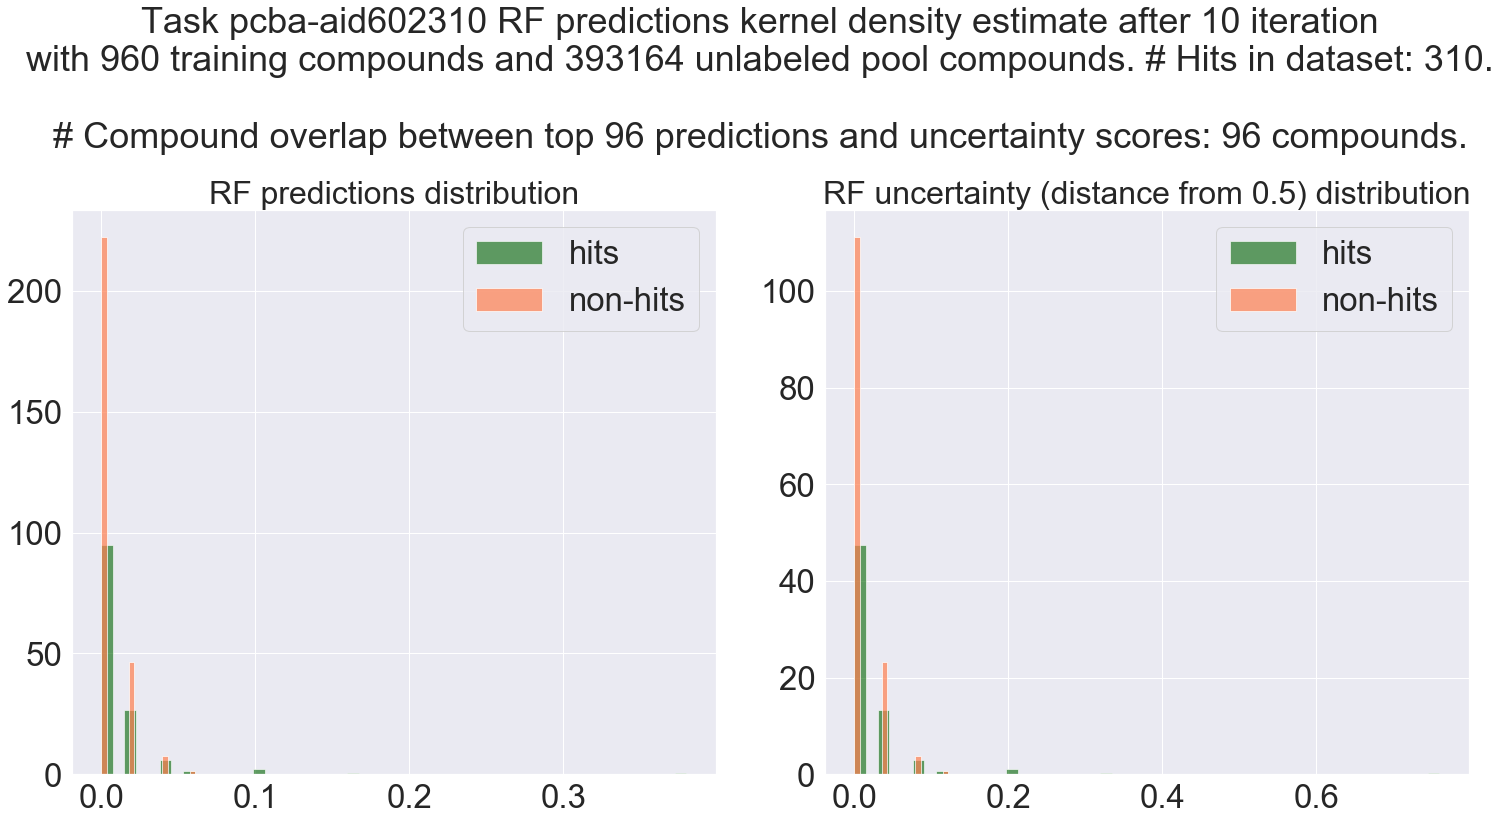

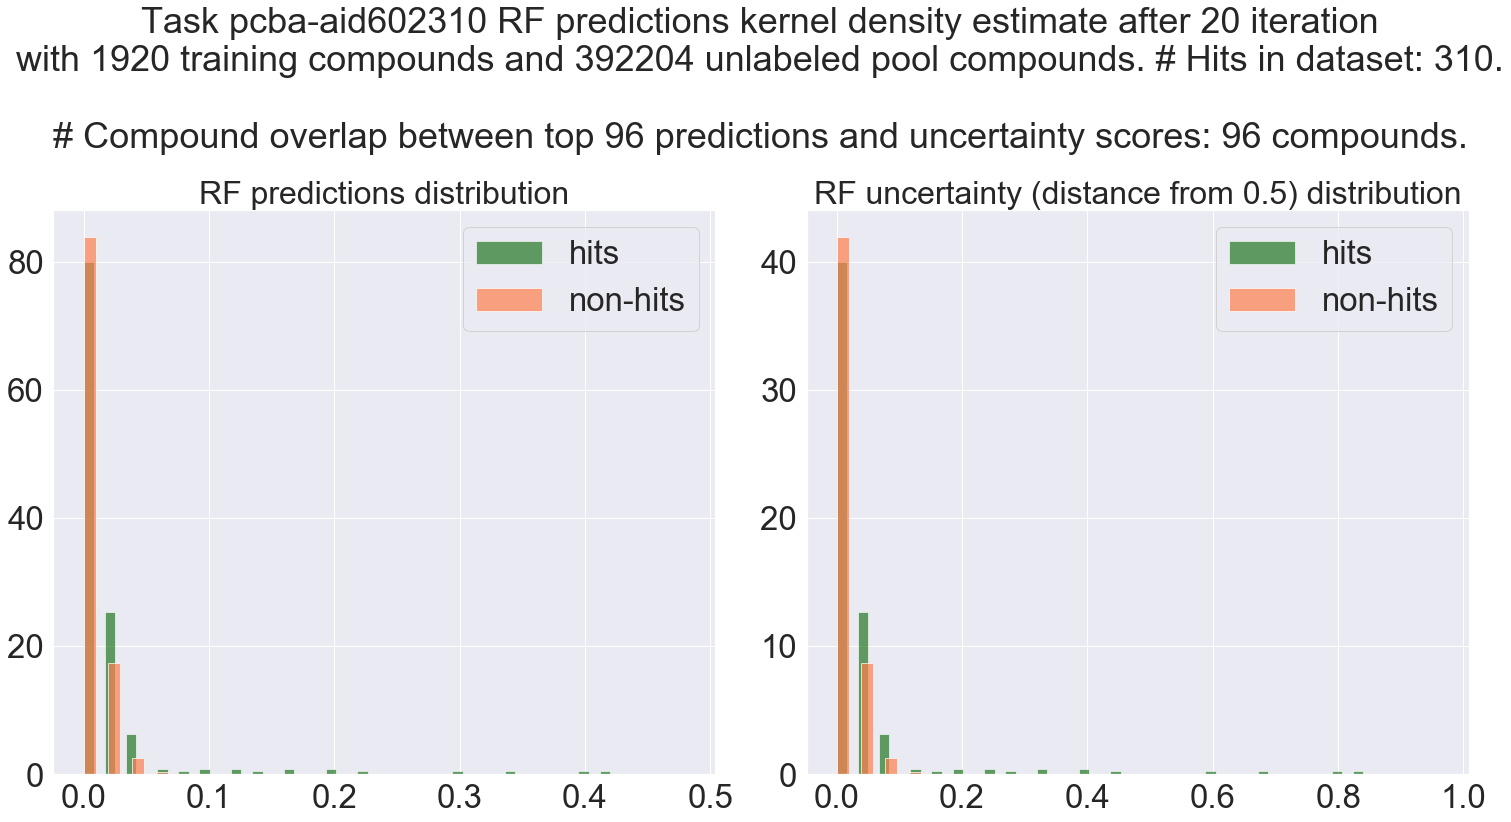

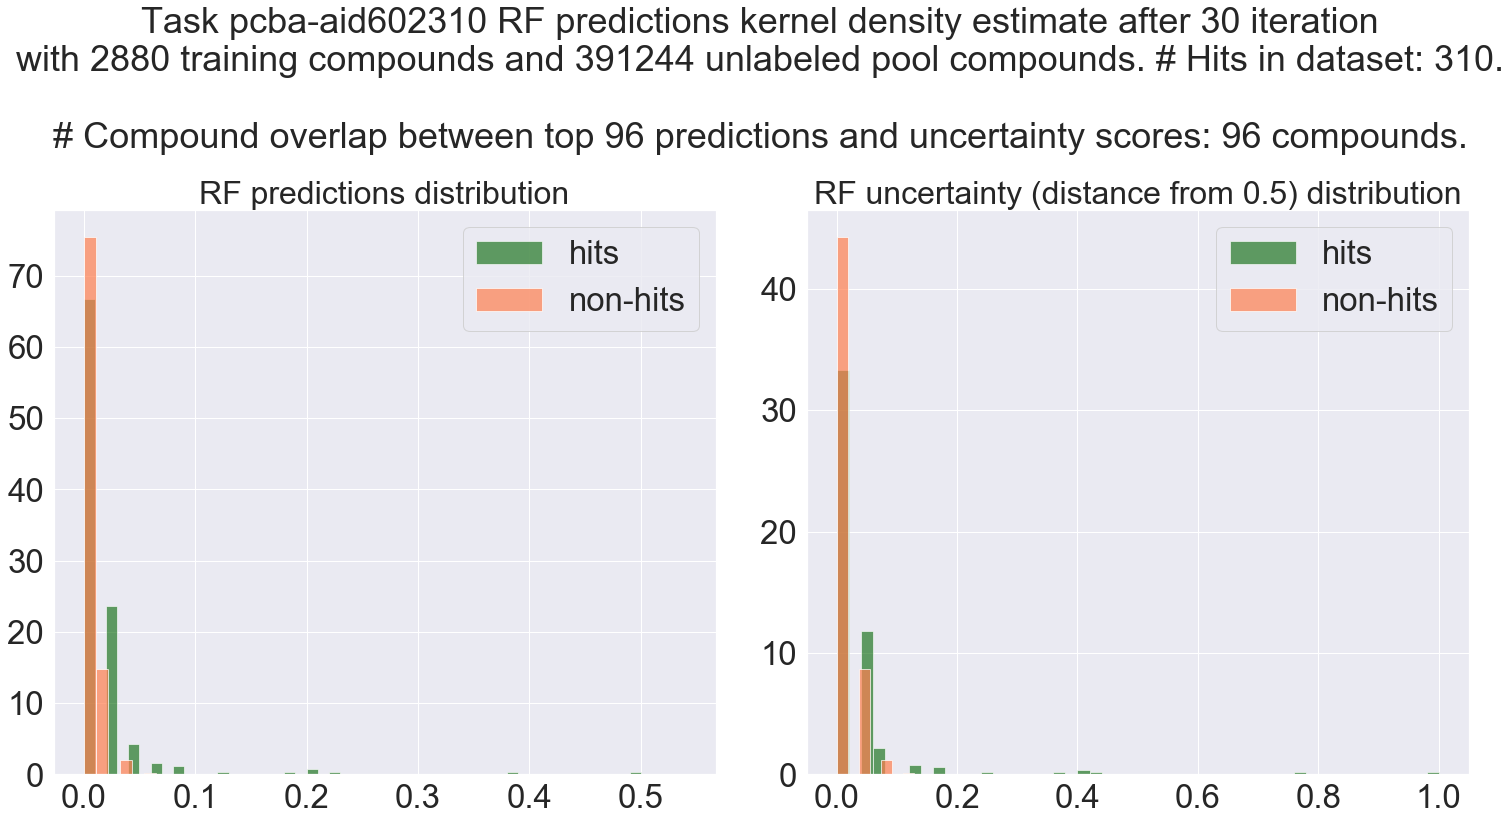

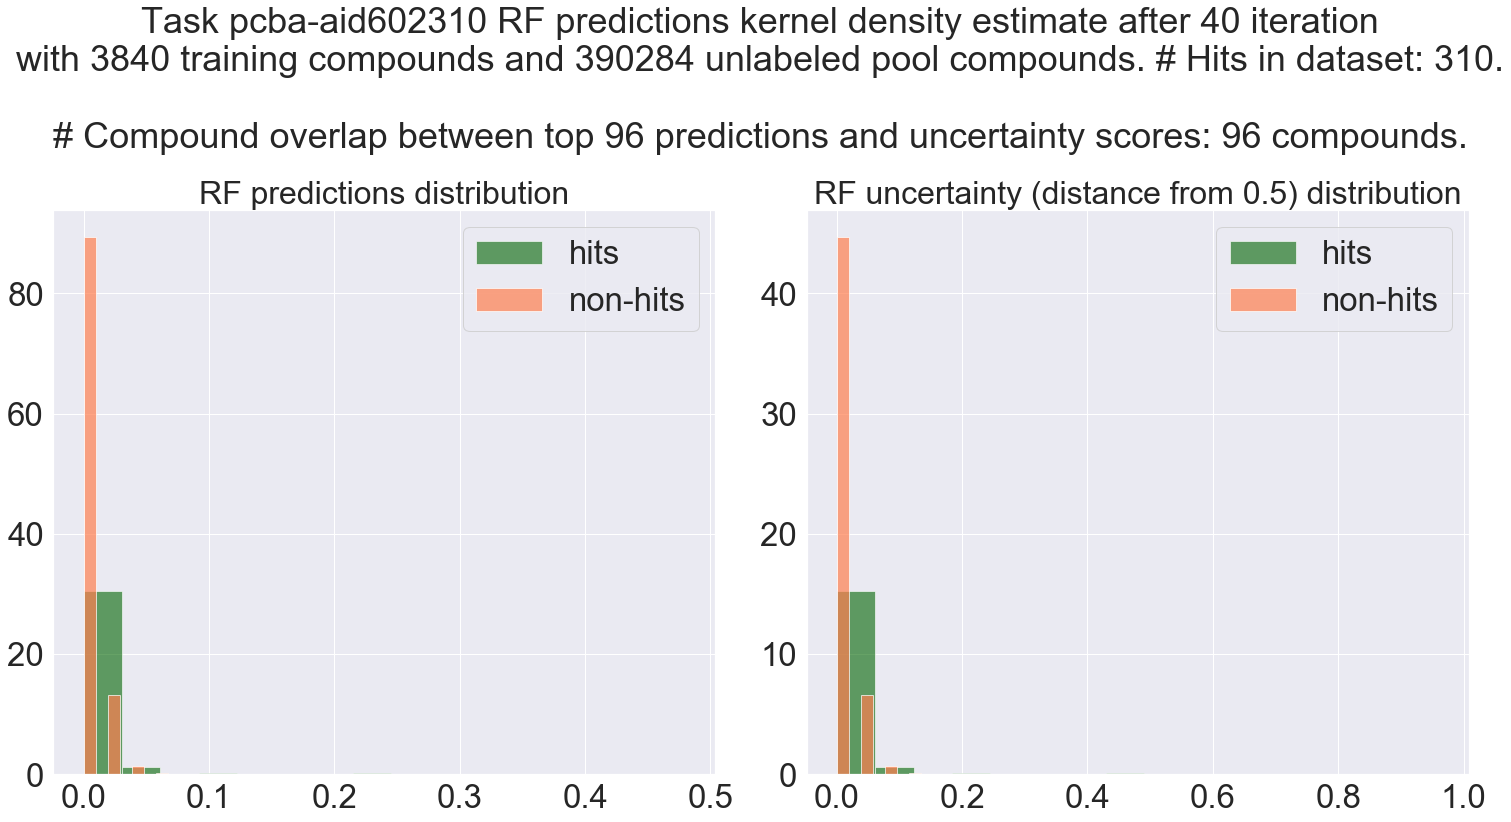

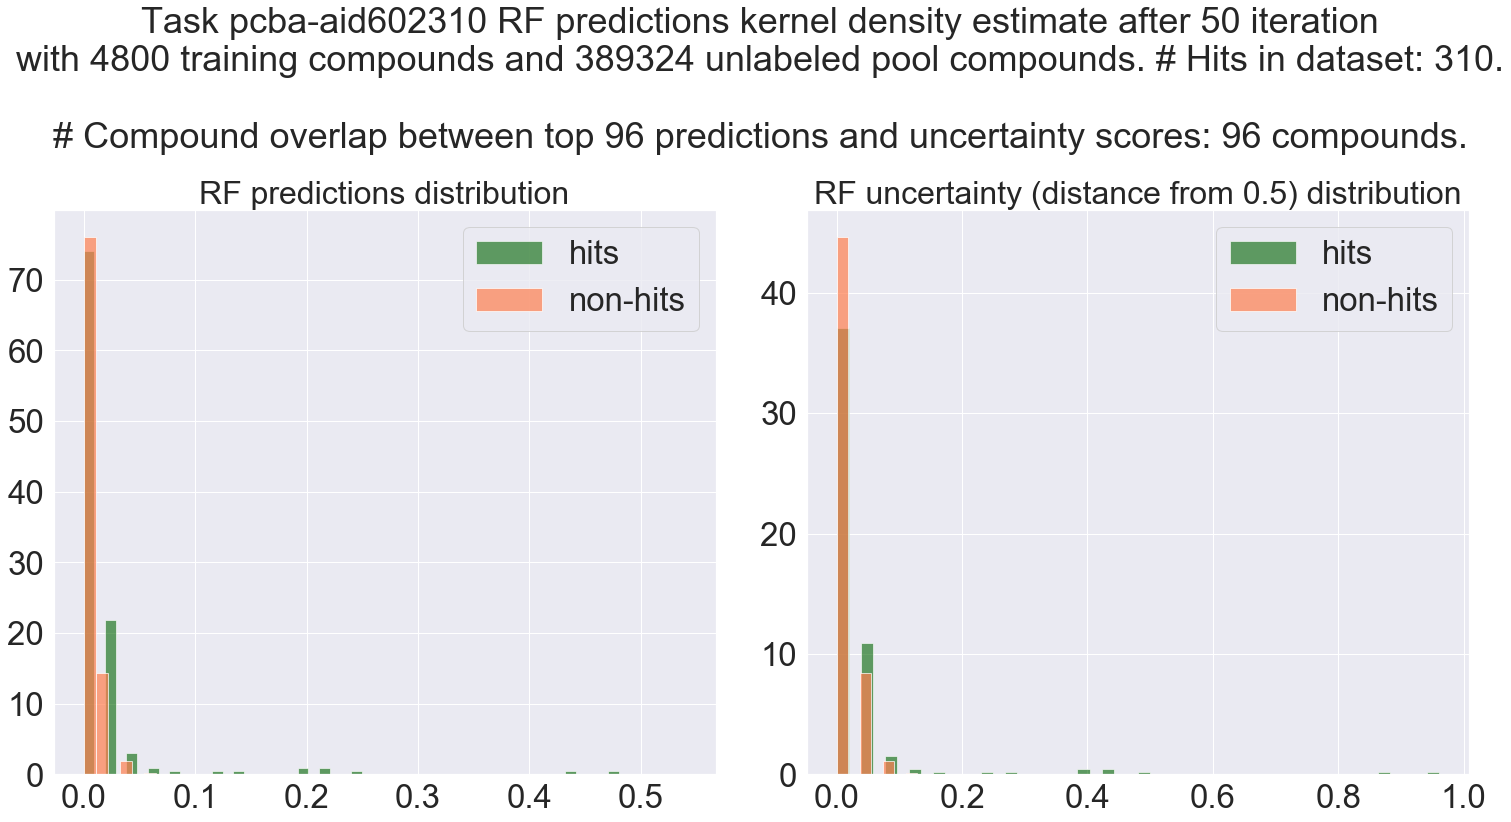

In [82]:
task_col, hit_perc, hit_limit = 'pcba-aid602310', 0.08, 310
run_rf(task_col, hit_perc, hit_limit)

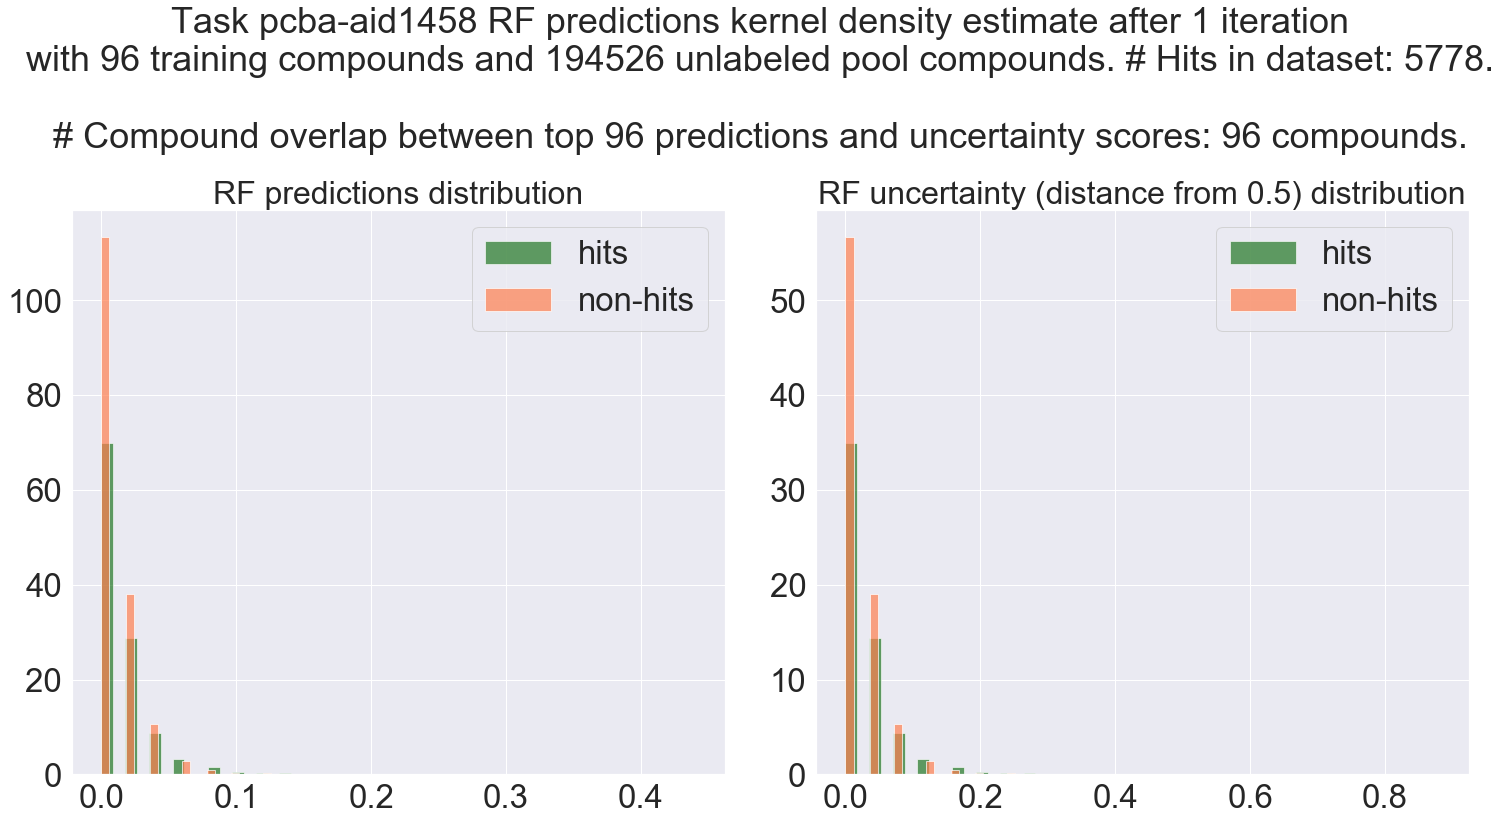

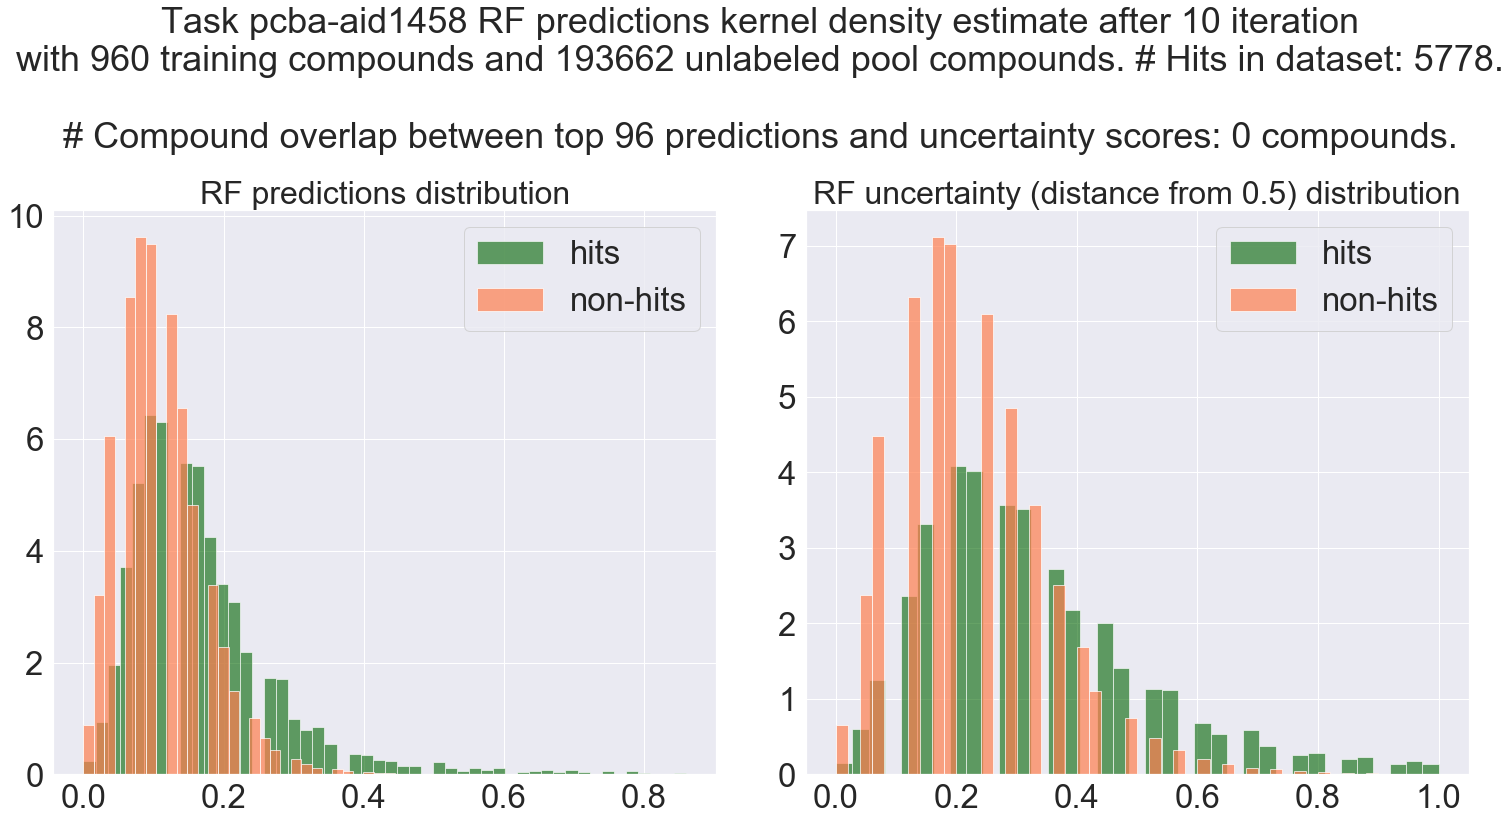

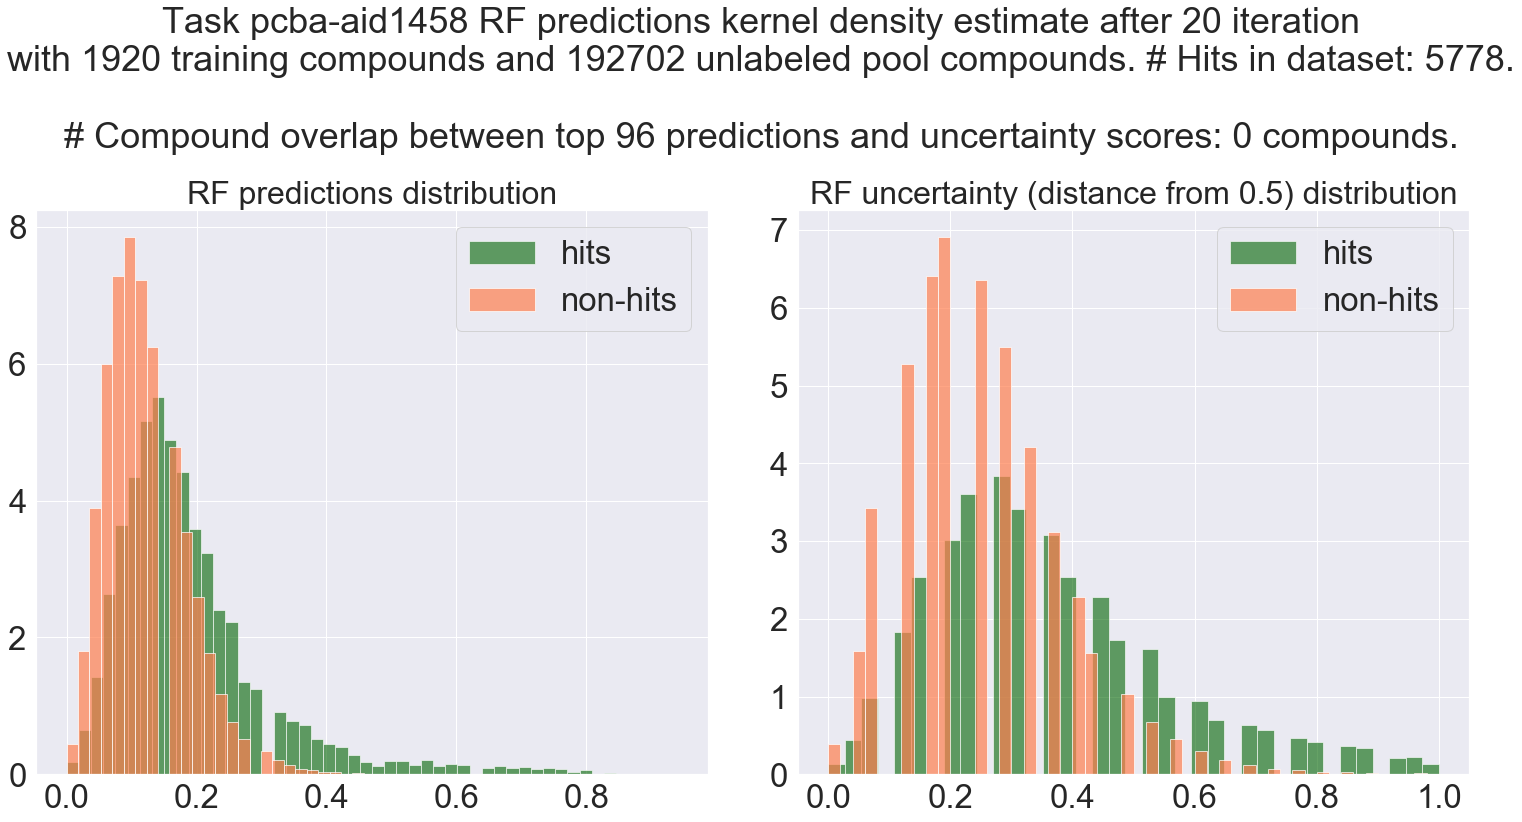

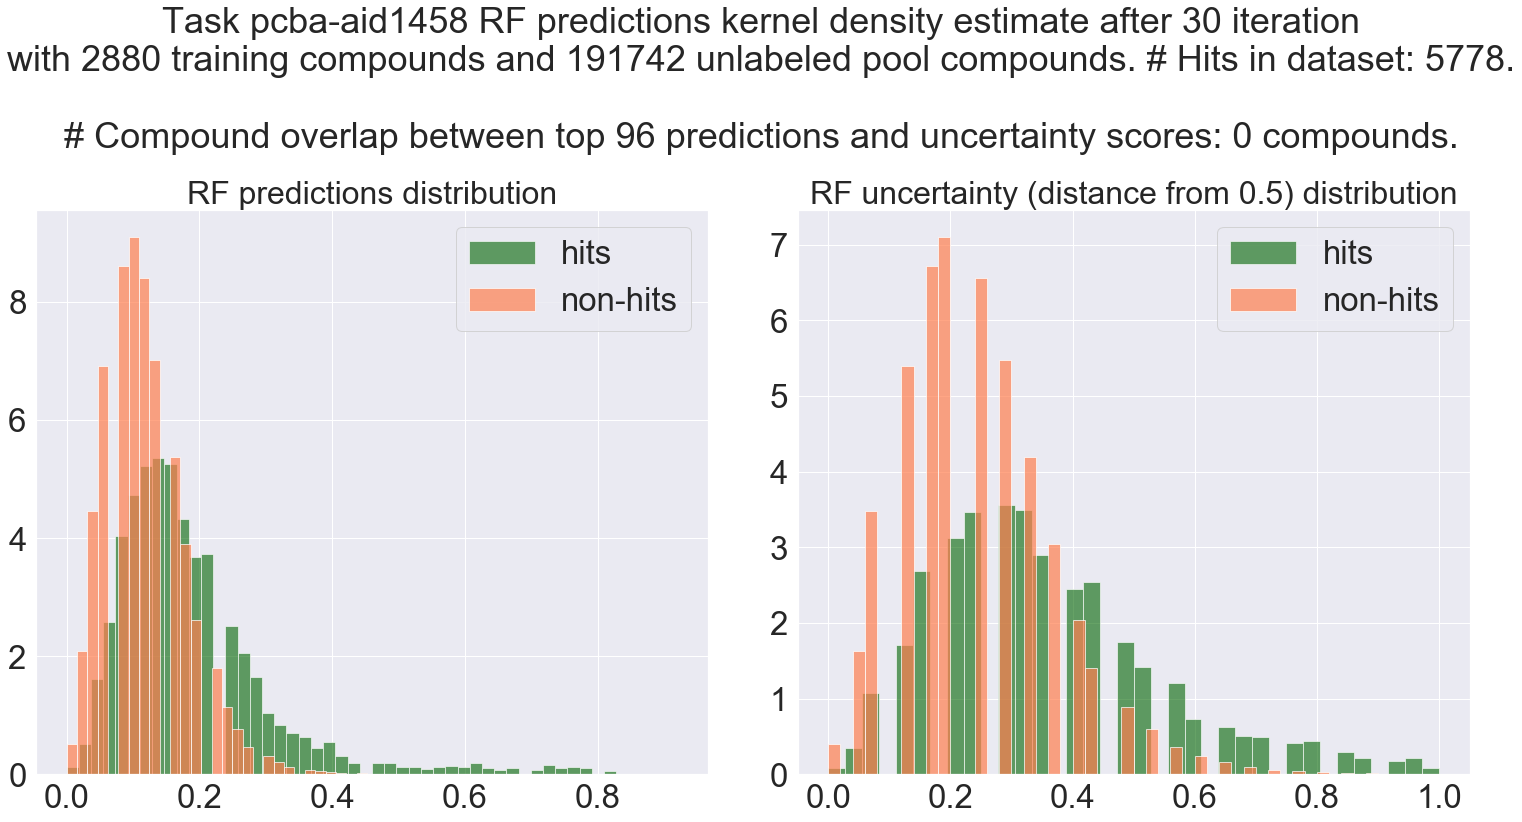

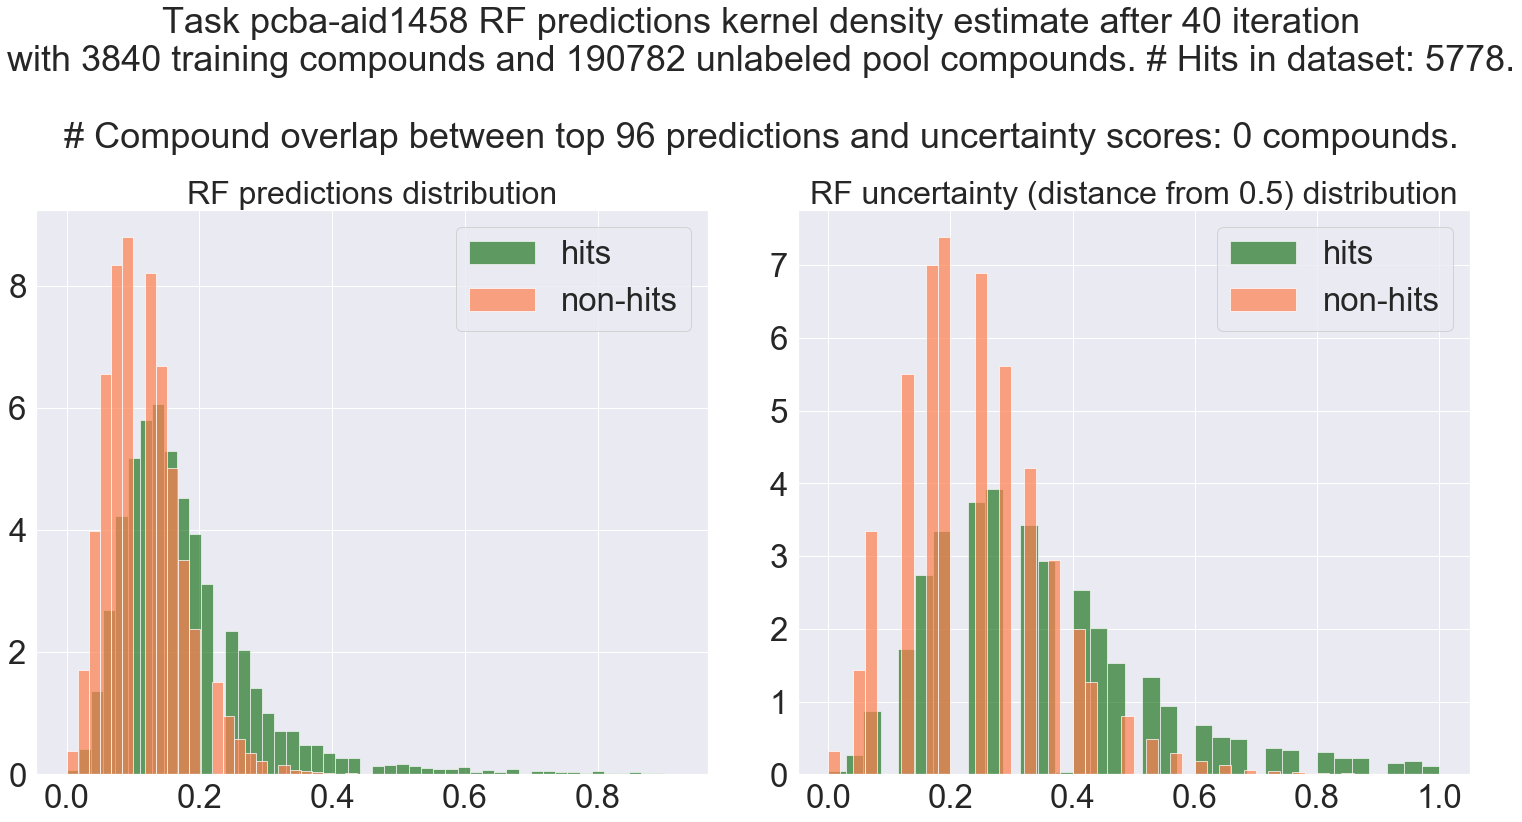

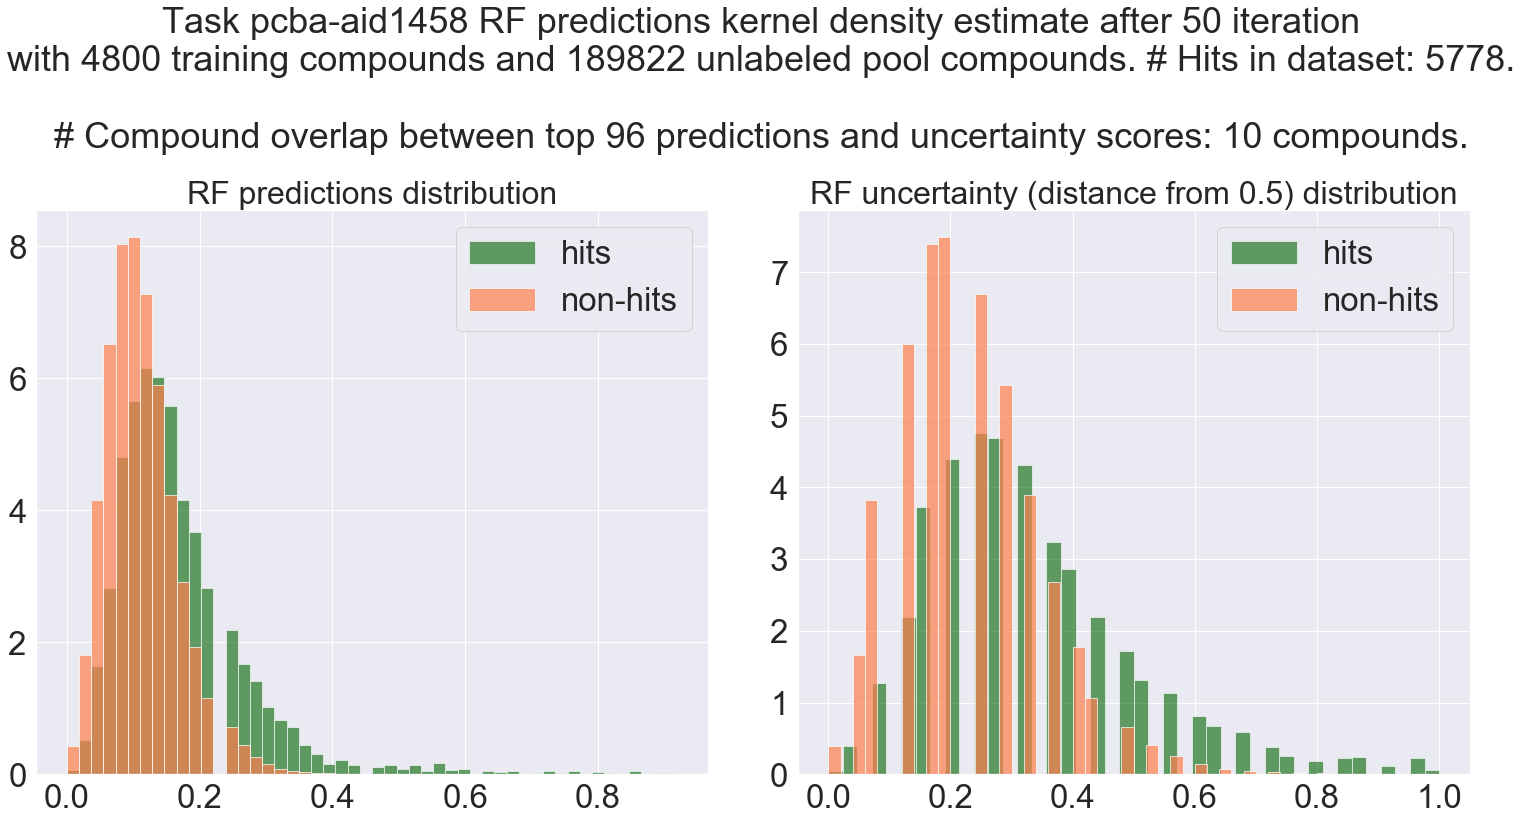

In [83]:
task_col, hit_perc, hit_limit = 'pcba-aid1458', 2.97, 5778
run_rf(task_col, hit_perc, hit_limit)

- This explains why exploration-heavy CBWS models are still able to find many actives. 
- At iteration 1, the range of the preds of random forest are small [0, 0.4] which means that activity score AND uncertainty score (distance from 0.5) give same ORDERING. In iterations 10 and after, range of scores depends on the hit % of the task. Tasks with fewer hits will have a small prediction range than task with more hits. This is likely due to the model not seeing enough hit examples to make a confident probability estimate. 

- The task pcba-aid602310 has 5778 hits which is one of the highest hit counts in 128-PCBA. With this task, we can see that the right tail of the uncertainty plots are heavier for hits (green) than non-hits (orange); more hits will be selected for exploration. This trend is still visible at 50 iterations.

- This explains why exploration-heavy CBWS models are still able to find many actives. 
- Mainly, the range of the preds of random forest are small [0, 0.3] in __early iterations__ which means that activity score AND uncertainty score (distance from 0.5) give same ORDERING. This means that exploration heavy models are effectively doing exploitation with diversity selection as well. 
- To fix/remedy this, we can probably normalize predictions of the tested pool in range from 0-1. This would show that uncertainty scores (distance from 0.5) is clearly different that activity score. 

- So in summary, early iterations it is likely that exploration-heavy and exploitation-heavy select similar cpds since activity vs uncertainty scores are similar, but in late iterations the range of scores becomes wider and so differences arise. 
- Perhaps a random forest method with soft boundaries is not suitable for iterative screening, we should try a neural network, which from our experience has more clear boundaries and wider range of scores early on. But again this can be suspect to overfitting. Perhaps a normalization 0-1 scheme will work too. 

---
# Per Task Overlap at 1, 10, 20, 30, 40, 50 iterations

In [ ]:
recompute_task_info=False
if recompute_task_info:
    task_names = [r.split('\\')[-2][:-6] for r in glob.glob('../datasets/pcba/*_cv_96/')]
    task_hit_dict = {}
    for task_col in task_names:
        task_df = pd.concat([pd.read_csv(x) for x in glob.glob('../datasets/pcba/{}_cv_96/unlabeled_*.csv'.format(task_col))])
        cpd_count = task_df.shape[0]
        hit_limit = task_df[task_col].sum()
        unique_hit_limit = task_df[task_df[task_col] == 1][cluster_col].unique().shape[0]
        task_hit_dict[task_col] = (hit_limit, unique_hit_limit, cpd_count)
else:
    import pickle
    with open('task_info_dict.pickle', 'rb') as handle:
        task_hit_dict = pickle.load(handle)
        
task_data = []
for tcol in task_hit_dict:
    a, b, c = task_hit_dict[tcol]
    task_data.append([tcol, a, b, c])

task_info = pd.DataFrame(data=task_data, columns=['task_col', 'hit_limit', 'unique_hit_limit', 'cpd_count'])
task_info['active_ratio'] = np.around(100.0 * task_info['hit_limit'] / task_info['cpd_count'], decimals=2)
task_info['hit_limit'] = task_info['hit_limit'].astype(int)
task_info = task_info[task_info['cpd_count'] > 100000]
full_task_info = task_info.copy()

excluded_tasks = ['pcba-aid588342','pcba-aid1030', 'pcba-aid504332', 
                  'pcba-aid686979', 'pcba-aid686978', 'pcba-aid624173']
task_info = full_task_info[~full_task_info['task_col'].isin(excluded_tasks)]
task_info = task_info.sort_values('active_ratio')

In [34]:
def get_task_overlap_rf(task_info, uncert_method='least_confidence', normalize_uncert=False):
    detailed_data = []
    task_data = []
    for i, row in task_info.iterrows():
        task_col, hit_limit, unique_hit_limit, cpd_count, active_ratio = row
        af = root_dir+'sampled_hyparams/ClusterBasedWCSelector_609/{}/0/batch_size_96/'.format(task_col)
        
        overlap_list = []
        for iter_max in [1, 10, 20, 30, 40, 50]:
            train_files = [af+'/training_data/iter_{}.csv'.format(i) for i in range(iter_max)]

            train_df = pd.concat([pd.read_csv(x) for x in train_files])
            unlabeled_df = pd.concat([pd.read_csv(x) for x in glob.glob('../datasets/pcba/{}_cv_96/*.csv'.format(task_col))])
            unlabeled_df = unlabeled_df.drop_duplicates('Index ID')
            unlabeled_df = unlabeled_df[~unlabeled_df['Index ID'].isin(train_df['Index ID'].values)]

            X_train = np.vstack([ (np.fromstring(x, 'u1') - ord('0')).astype(np.uint16) for x in train_df['Morgan FP_2_1024'] ])
            X_test = np.vstack([ (np.fromstring(x, 'u1') - ord('0')).astype(np.uint16) for x in unlabeled_df['Morgan FP_2_1024'] ])
            y_train, y_test = train_df[task_col].values.reshape(-1,1), unlabeled_df[task_col].values.reshape(-1,1)

            model = sklearn_randomforest.SklearnRF(task_names=[task_col],
                                                   n_estimators=50,
                                                   max_features="log2",
                                                   min_samples_leaf=1,
                                                   n_jobs=1,
                                                   class_weight="balanced",
                                                   random_state=20183112,
                                                   oob_score=False,
                                                   verbose=0)
            model.fit(X_train, y_train)
            train_preds = model.predict(X_train)
            test_preds = model.predict(X_test)
            test_uncert = model.get_uncertainty(X_test, uncert_method, [])

            if normalize_uncert:
                x = (test_preds - np.min(test_preds)) / (np.max(test_preds) - np.min(test_preds))
                test_uncert = 1 - (np.abs(2*x - 1))

            test_actives = np.where(y_test[:,0] == 1)[0]
            test_inactives = np.where(y_test[:,0] == 0)[0]

            topk = 96
            x = test_preds[:,0].argsort()[::-1][:topk]
            y = test_uncert[:,0].argsort()[::-1][:topk]
            overlap = np.intersect1d(x, y).shape[0]
            
            detailed_data.append([task_col, hit_limit, unique_hit_limit, cpd_count, active_ratio, 
                                  iter_max, y_train.shape[0], y_test.shape[0], overlap])
            
            overlap_list.append(overlap)
            
        task_data.append([task_col, hit_limit, unique_hit_limit, cpd_count, active_ratio] + overlap_list)
            
    detailed_overlap_df = pd.DataFrame(data=detailed_data, 
                                       columns=['task_col', 'hit_limit', 'unique_hit_limit', 'cpd_count', 'active_ratio',
                                                'iter_max', 'train_size', 'unlabeled_size', 'overlap'])
    task_overlap_df = pd.DataFrame(data=task_data, 
                                   columns=['task_col', 'hit_limit', 'unique_hit_limit', 'cpd_count', 'active_ratio',
                                            'overlap_1', 'overlap_10', 'overlap_20', 'overlap_30', 'overlap_40', 'overlap_50'])
    
    return detailed_overlap_df, task_overlap_df 

In [35]:
df_from_file=True
if not df_from_file:
    detailed_overlap_df, task_overlap_df = get_task_overlap_rf(task_info)
else:
    detailed_overlap_df = pd.read_csv('./exp3/detailed_overlap_df.csv.gz')
    task_overlap_df = pd.read_csv('./exp3/task_overlap_df.csv.gz')

In [65]:
overlap_cols = ['overlap_1', 'overlap_10', 'overlap_20', 'overlap_30', 'overlap_40', 'overlap_50']
des_cols = ['task_col', 'hit_limit', 'cpd_count', 'active_ratio'] + overlap_cols + ['avg_overlap']
task_overlap_df['avg_overlap'] = task_overlap_df[overlap_cols].mean(axis=1)

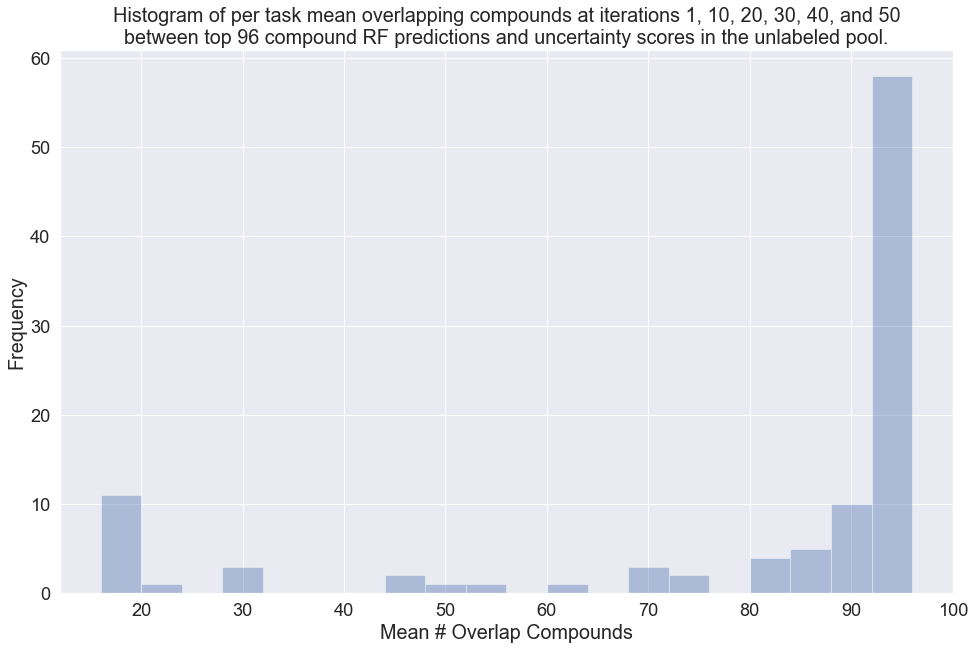

In [72]:
 import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context("paper")
sns.set(font_scale=1.65)

figsize=(16, 10)
title = 'Histogram of per task mean overlapping compounds at iterations 1, 10, 20, 30, 40, and 50\n'
title += 'between top 96 compound RF predictions and uncertainty scores in the unlabeled pool.'
plt.figure(figsize=figsize)
sns.distplot(task_overlap_df['avg_overlap'].values, bins=20, kde=False)
plt.xlabel('Mean # Overlap Compounds'); plt.ylabel('Frequency');
plt.title(title);

In [73]:
x = task_overlap_df[des_cols]
x.columns = ['Task ID', '# Task Hits', '# Task Compounds',
             'Hit \%', '# Overal 1 iterations', '# Overal 10 iterations', 
             '# Overal 20 iterations', '# Overal 30 iterations',
             '# Overal 40 iterations', '# Overal 50 iterations', 'Mean # Overlap']
display(x)
#print(x.drop(['# Task Hits', '# Task Compounds'], axis=1).round(2).to_latex(index=False, longtable=True))

,Task ID,# Task Hits,# Task Compounds,Hit \%,# Overal 1 iterations,# Overal 10 iterations,# Overal 20 iterations,# Overal 30 iterations,# Overal 40 iterations,# Overal 50 iterations,Mean # Overlap
0,pcba-aid588456,51,384401,0.01,96,96,96,96,96,96,96.000000
1,pcba-aid463254,41,329208,0.01,89,96,96,96,96,96,94.833333
2,pcba-aid504891,34,361253,0.01,96,96,96,96,96,96,96.000000
3,pcba-aid602332,69,408382,0.02,96,96,96,96,96,96,96.000000
4,pcba-aid492947,80,329377,0.02,96,96,96,96,96,96,96.000000
5,pcba-aid624246,101,364607,0.03,96,96,96,96,96,96,96.000000
6,pcba-aid504845,100,372364,0.03,96,96,96,96,96,96,96.000000
7,pcba-aid504842,101,324667,0.03,96,96,96,96,96,96,96.000000
8,pcba-aid2662,110,285346,0.04,96,96,96,96,96,96,96.000000
9,pcba-aid602233,165,379215,0.04,96,96,96,96,96,96,96.000000


In [ ]:
tasks = ['pcba-aid588456', 'pcba-aid602310', 'pcba-aid1458']

for task_col in tasks:
    for iter_max in [1, 10, 20, 30, 40, 50]:
        s = '\\begin{subfigure}{\includegraphics[width=0.75\linewidth]{'
        s += 'project_al/experiments/exp_uncertainty_check/side_by_side/'
        s += 'task_{}_{}.png'.format(task_col, iter_max)
        s += '}}\\end{subfigure}'
        print(s)

In [79]:
task_overlap_df[task_overlap_df['task_col'].isin(tasks)][['task_col', 'hit_limit', 'active_ratio', 'cpd_count']]

,task_col,hit_limit,active_ratio,cpd_count
0,pcba-aid588456,51,0.01,384401
21,pcba-aid602310,310,0.08,394124
94,pcba-aid1458,5778,2.97,194622


---
# Experiment 2 CBWS Exploration Strategies

In [85]:
explore_strats_short = ['CBWS_609', 'CBWS_411', 'CBWS_678', 'CBWS_55', 'CBWS_590', 'CBWS_396', 'CBWS_341', 'CBWS_467']
explore_strats = [x.replace('CBWS', 'ClusterBasedWCSelector') for x in explore_strats_short]

config_files = ['../param_configs/experiment_2_hyperparams/sampled_hyparams/{}.json'.format(x) for x in explore_strats]

import json
des_cols = ['exploitation_alpha', 'exploitation_activity_threshold', 'exploitation_weight_threshold', 
            'exploitation_use_quantile_for_activity', 'exploitation_use_quantile_for_weight']
data = []
for cf in config_files:
    with open(cf, 'r') as f:
        config = json.load(f)
    config_data = []
    for k in des_cols:
        config_data.append(config[k])
    data.append(config_data)
    
config_df = pd.DataFrame(data=data, columns=des_cols, index=explore_strats_short)

In [86]:
config_df

,exploitation_alpha,exploitation_activity_threshold,exploitation_weight_threshold,exploitation_use_quantile_for_activity,exploitation_use_quantile_for_weight
CBWS_609,0.75,0.50,1.00,False,False
CBWS_411,0.25,0.50,0.00,False,False
CBWS_678,0.50,0.25,0.50,True,False
CBWS_55,0.75,1.00,1.00,False,True
CBWS_590,0.25,0.50,0.50,False,True
CBWS_396,0.25,0.25,0.50,True,False
CBWS_341,1.00,0.75,0.75,True,False
CBWS_467,0.75,0.75,0.25,False,False


In [ ]:
print(config_df.to_latex())